### Volcano plots from Top3 proteomics data

- The notebook requires Top3 data from proteomics with individual replicates
- Originally designed for iterative upload of DBTL data (7 rounds)
    - Substitute with your own data of interest

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from adjustText import adjust_text

#### Import Top3 data of interest

Load Top3 data from each of the DBTL cycles for analysis

In [2]:
# Define the filenames and the samples of interest
filenames = [f'DBTL{i}.csv' for i in range(7)]

# Load CSV files and concatenate into a single dataframe
dataframes = [pd.read_csv(filename) for filename in filenames]
combined_df = pd.concat(dataframes, ignore_index=True)

Check header

In [3]:
combined_df.head()

,Protein.Group,Protein.Names,Protein,Protein.Description,Sample,Replicate,Top_3pep_counts_mean,%_of protein_abundance_Top3-method,log10_%_abundance,Cycle
0,P00552,KKA2_KLEPN,Neo,Aminoglycoside 3'-phosphotransferase,Control,R1,119112382.0,3.112624,0.493127,0
1,P00552,KKA2_KLEPN,Neo,Aminoglycoside 3'-phosphotransferase,Control,R2,149172095.3,3.712705,0.569690,0
2,P00552,KKA2_KLEPN,Neo,Aminoglycoside 3'-phosphotransferase,Control,R3,138700868.7,3.700489,0.568259,0
3,P00552,KKA2_KLEPN,Neo,Aminoglycoside 3'-phosphotransferase,Control,R4,100306326.3,2.650788,0.423375,0
4,P00552,KKA2_KLEPN,Neo,Aminoglycoside 3'-phosphotransferase,Control,R5,114276780.7,2.835433,0.452619,0


Translate Top3 proteins into locus identities and then transform all of the uploaded concatenated .csvs

In [4]:
# Load the name_df DataFrame for translation
name_df = pd.read_csv('proteomics_id_translator_240305.csv') 

# Create a dictionary from the name_df for fast lookup
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

# Use the dictionary to map the Protein.Group names to locus names
combined_df['Protein.Group'] = combined_df['Protein.Group'].map(lambda x: translator_dict.get(x, x))

# Count the number of non-translated protein groups
nontranslated = combined_df['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(combined_df['Protein.Group'])} proteins were not translated to locus names")

In total, N = 19710/2544333 proteins were not translated to locus names


### Initialize a DataFrame to store log2 and log10 values for all samples

Include samples across all cycles to be analyzed

##### These will be compared against your "controls"

In [5]:
samples_of_interest = [
    "PP_0812_PP_0813_PP_0815",
    "PP_0812_PP_0814_PP_0815",
    "PP_0813_PP_0814_PP_0815"]
    
 # "PP_0812_PP_0813_PP_0815",
 # "PP_0812_PP_0814_PP_0815",
 # "PP_0813_PP_0814_PP_0815",
 # "PP_0813_PP_0815",
 # "PP_0815",
 # "PP_0814_PP_0815"]

# "PP_0812_PP_0813",
# "PP_0812_PP_0814",
# "PP_0812_PP_0813_PP_0814",
# "PP_0813_PP_0814",
# "PP_0812",
# "PP_0813",
# "PP_0814"]


#### Define your controls
- Pairwise comparison of samples_of_interest to the defined controls pooled across all cycles

In [6]:
# Initialize an empty DataFrame to store log2 and log10 results
log2_log10_results = pd.DataFrame()
sample_control_pairs = {sample: "Control" for sample in samples_of_interest}

#### Set thresholds for the volcano plots 
- p-value threshold and log2 fold_change threshold
- filtering Top3 data 

In [7]:
# Define thresholds for filtering
# Use 1 if simply looking for any differences between a strain and a control
fold_change_threshold = 1 
log2_fold_change_threshold= np.log2(fold_change_threshold)

p_value_threshold = 0.05
top3_filter = 0.001

### Generate volcano plots
- Sample pairs vs. control

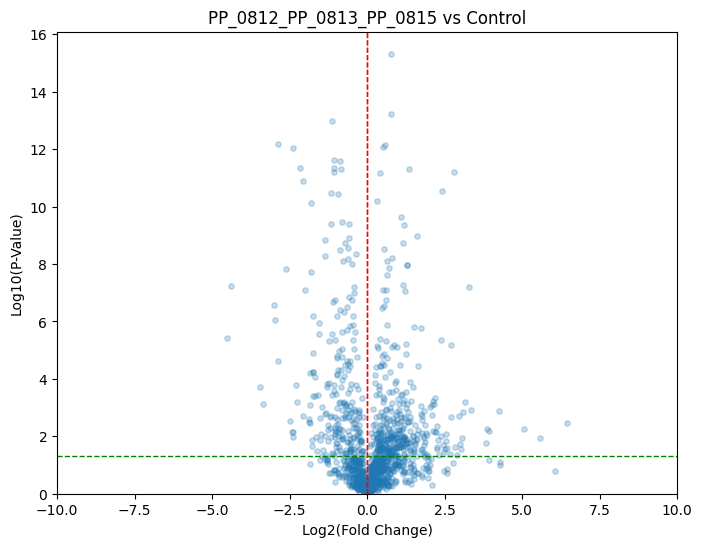

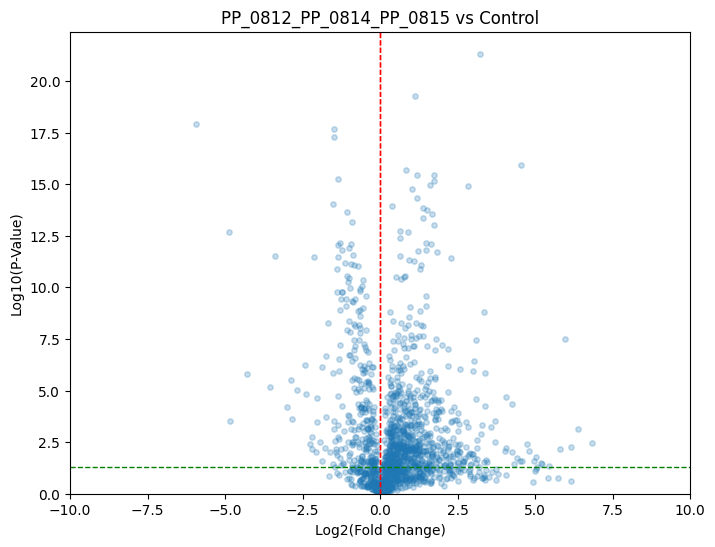

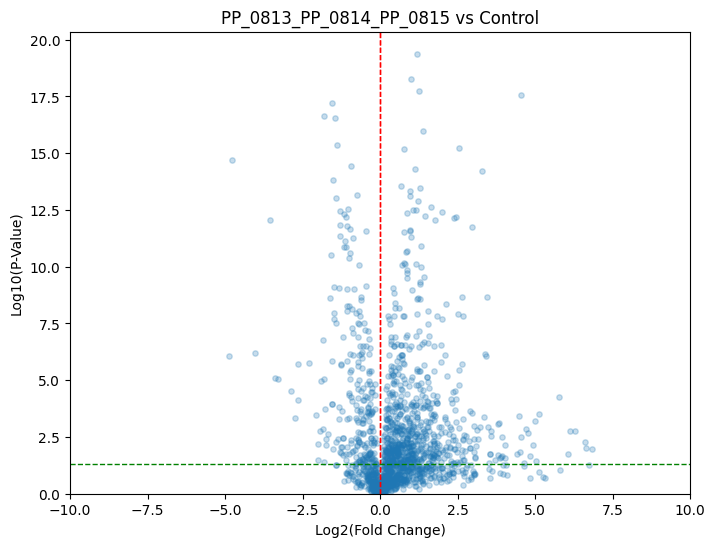

Log2 and Log10 values saved to 'Volcano_Results.csv'


In [8]:
# Initialize the results DataFrame before the loop
log2_log10_results = pd.DataFrame()

for sample, control in sample_control_pairs.items():
    sample_data = combined_df[combined_df['Sample'] == sample]
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)

    # Filter reference_mean to include only abundances > top3_filter
    sample_mean = sample_mean[sample_mean['sample_abundance'] > top3_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if not filtered_data.empty:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )

        # Merge with the main results DataFrame
        if log2_log10_results.empty:
            log2_log10_results = temp_results
        else:
            log2_log10_results = pd.merge(
                log2_log10_results,
                temp_results,
                on='Protein.Group',
                how='outer'
            )

    # Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']

    plt.figure(figsize=(8, 6))
    plt.scatter(fold_change, p_values, s=15, alpha=0.25)
    plt.title(f"{sample} vs {control}")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0,)
    plt.xlim(-10, 10)

    # Threshold lines
    plt.axvline(x=log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=-log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=-np.log10(p_value_threshold), color='g', linestyle='--', linewidth=1)

    # Show the plot
    plt.show()

    #Annotate significant points; this adds arrows to each of the plots and is computationally intensive, will probably crash if threshold zero
    # texts = []
    # labels = merged_data['Protein.Group']
    # for i, label in enumerate(labels):
    #     if (fold_change[i] > log2_fold_change_threshold or fold_change[i] <-log2_fold_change_threshold) and p_values[i] > -np.log10(p_value_threshold):
    #         text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
    #         texts.append(text)

    # if texts:
    #     adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

    #Show the plot
    plt.show()

# Save the filtered log2 and log10 values to a CSV file
if not log2_log10_results.empty:
    log2_log10_results.to_csv('Volcano_Results.csv', index=False)
    print("Log2 and Log10 values saved to 'Volcano_Results.csv'")
else:
    print("No significant results to save.")

### Investigating genes that are upregulated amongst a subset of samples

#### TCA Cycle

In [21]:
# Define the list of proteins
pathway_name = "Proteins_TCA_Superpathway"
proteins_txt = pd.read_csv('pathway-genes-TCA.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Filter the data to include only the proteins that are significant for all samples of interest
filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the TCA cycle were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

8 out of 21 genes in the TCA cycle were significantly changed across strains
Those genes were:
Gene Accession Gene name                  Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_0751      mqo1       malate:quinone oxidoreductase                        -0.265103                         0.583448                         0.658861                            2.834462                            5.241256                            4.778796
       PP_1251      mqo2       malate:quinone oxidoreductase                         1.268441                         1.693797                         1.681209                            4.869883                            3.920037                            3.988405
       PP_4185      sucD             succinyl-CoA synthetase                        -1.800746        

#### Branched Chain AA Superpathway

In [22]:
# Define the list of proteins
pathway_name = "Proteins_AA_Superpathway"
proteins_txt = pd.read_csv('pathway-genes-BRANCHED-CHAIN-AA-SYN-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])

# Compare the filtered data against the second list of proteins
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the AA superpathway were significantly changed across strains")
# Merge the matching proteins with the proteins_txt DataFrame to get additional information
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
# Include columns for p-values and fold changes for the samples of interest
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')


# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

7 out of 16 genes in the AA superpathway were significantly changed across strains
Those genes were:
Gene Accession Gene name                         Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_1985      leuC              3-isopropylmalate dehydratase                         0.379337                        -0.222430                        -0.228460                            3.660420                            3.883572                            2.383105
       PP_1988      leuB            3-isopropylmalate dehydrogenase                        -0.320979                        -0.231107                        -0.162479                            2.284970                            6.155879                            4.351161
       PP_3511      ilvE branched-chain-amino acid aminotransferase       

#### Glycolysis Genes

In [23]:
# Define the list of proteins
pathway_name = "Proteins_Glycolysis"
proteins_txt = pd.read_csv('pathway-genes-PWY1G01-2.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total
print(f"{included} out of {total} genes in glycolysis were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

13 out of 34 genes in glycolysis were significantly changed across strains
Those genes were:
Gene Accession Gene name                                                  Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_1011       glk                                                         glucokinase                         0.736293                         0.302492                         0.402083                            1.517794                            2.133207                            1.403027
       PP_1023       pgl                                           6-phosphogluconolactonase                         0.450959                         0.253691                         0.390912                            4.456436                            1.761662                            1.507395
       

#### Non-oxidative PP Pathway

In [24]:
# Define the second list of proteins
pathway_name = "Proteins_Non_Oxidative_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-NONOXIPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

1 out of 4 genes were significantly changed across strains
Those genes were:
Gene Accession Gene name Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_4965      tktA    transketolase A                         0.521512                         0.678229                         0.634629                            7.096329                            4.871664                            4.148253


#### Oxidative PP Pathway

In [25]:
# Define the list of proteins
pathway_name = "Proteins_Oxidative_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-OXIDATIVEPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

1 out of 5 genes were significantly changed across strains
Those genes were:
Gene Accession Gene name        Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_1023       pgl 6-phosphogluconolactonase                         0.450959                         0.253691                         0.390912                            4.456436                            1.761662                            1.507395


#### PP Pathway

In [26]:
# Define the list of proteins
pathway_name = "Proteins_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-PENTOSE-P-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

2 out of 9 genes were significantly changed across strains
Those genes were:
Gene Accession Gene name        Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_1023       pgl 6-phosphogluconolactonase                         0.450959                         0.253691                         0.390912                            4.456436                            1.761662                            1.507395
       PP_4965      tktA           transketolase A                         0.521512                         0.678229                         0.634629                            7.096329                            4.871664                            4.148253


#### Oxidative Phosphorylation

In [27]:
# Define the second list of proteins
pathway_name = "Proteins_Oxidative_Phosporylation_Pathway"
proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Pooled.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

3 out of 32 genes were significantly changed across strains
Those genes were:
Gene Accession Gene name                           Enzymatic activity  PP_0812_PP_0813_PP_0815_log2_FC  PP_0812_PP_0814_PP_0815_log2_FC  PP_0813_PP_0814_PP_0815_log2_FC  PP_0812_PP_0813_PP_0815_log10_pval  PP_0812_PP_0814_PP_0815_log10_pval  PP_0813_PP_0814_PP_0815_log10_pval
       PP_4124      nuoG NADH:ubiquinone reductase (H+-translocating)                        -0.559504                        -0.292487                        -0.329060                            3.630982                            3.302834                            2.749242
       PP_4251    ccoO-I                  Cbb3-1 cytochrome c oxidase                         1.484824                         1.828913                         1.202505                            1.439093                            2.369335                            1.874522
       PP_5415      atpA                                 ATP synthase                      